<a href="https://colab.research.google.com/github/pradyot-09/DL-Reproducibility-Project/blob/master/CNNModel.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [9]:
# Import pytorch basic functions/classes
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

# Import torchvision functions/classes for MNIST import and data loaders
import torchvision
import torchvision.transforms as transforms

# Import numpy to use its wonderfull array implementation
import numpy as np

# Import other libraries for the confusion matrix
import seaborn as sn
import pandas as pd
import matplotlib.pyplot as plt

# Set device on which code is run
device = 'cuda'

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [2]:
# Define transform from PIL image to tensor and normalize to 1x768 pixels
transform_train = transforms.Compose([
  transforms.RandomAffine(0, (1/14, 1/14)),
  transforms.Resize(28),
  transforms.CenterCrop(28),
  transforms.ToTensor(),
  transforms.Normalize((0.5, ), (0.5, ))
])

transform_test = transforms.Compose([
  transforms.Resize(28),
  transforms.CenterCrop(28),
  transforms.ToTensor(),
  transforms.Normalize((0.5, ), (0.5, ))
])

# Set batch size for data loaders
batch_size = 32

# (Down)load training set
trainset = torchvision.datasets.MNIST(root='./data', train=True, download=True, transform=transform_train)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True, num_workers=2)

# (Down)load test set
testset = torchvision.datasets.MNIST(root='./data', train=False, download=True, transform=transform_test)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size, shuffle=False, num_workers=2)

Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw



Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw


Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw
Processing...
Done!


In [0]:
# Define CNN model and its layers
class CNNModel(nn.Module):

    def __init__(self, hidden_size=128, dropout=0.25, hidden_dropout=0.5):
        super(CNNModel, self).__init__()
        self.conv1 = nn.Conv2d(1, 8, kernel_size=5, padding=4)
        self.conv2 = nn.Conv2d(8,16, kernel_size=5, stride=2)
        self.dropout1 = nn.Dropout2d(dropout)
        self.dropout2 = nn.Dropout2d(hidden_dropout)
        self.fc1 = nn.Linear(784, hidden_size*2)
        self.fc2 = nn.Linear(hidden_size*2, hidden_size)
        self.fc3 = nn.Linear(hidden_size, 10)

    def forward(self, x):
        # First convolution and activation
        x = self.conv1(x)
        x = F.relu(x)
        # Second convolution, max pool and activation
        x = self.conv2(x)
        x = F.max_pool2d(x, 2)
        x = F.relu(x)
        # Flatten input into 1d tensor and random dropout to increase generalization
        x = torch.flatten(x, 1)
        x = self.dropout1(x)
        # First FFN layer, activation and dropout
        x = self.fc1(x)
        x = F.relu(x)
        x = self.dropout2(x)
        # Second FFN layer and activation
        x = self.fc2(x)
        x = F.relu(x)
        # Last FFN layer
        return self.fc3(x)

In [4]:
# Setup model and move it to the GPU
net = CNNModel()
net.to(device)

# Set up loss function and optimizer:
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(net.parameters(), lr=0.0001, weight_decay=0.00001)

# Run over 100 epochs (1 epoch = visited all items in dataset)
for epoch in range(100): #200 for SGD reaches 0.002 loss

    running_loss = 0.0
    total = 0
    for i, (inputs, labels) in enumerate(trainloader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs = inputs.to(device)
        target = labels.to(device).long()

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, target)
        loss.backward()
        optimizer.step()

        total += len(inputs)

        # print statistics
        running_loss += loss.item()
    # print every epoch
    print('[%d] loss: %.3f' % (epoch + 1, running_loss / total))

print('Finished Training')

# Save model after having finished training
PATH = './mnist_dropout_100_epoch.pth'
torch.save(net.state_dict(), PATH)

print('Saved Model')

[1] loss: 0.025
[2] loss: 0.010
[3] loss: 0.007
[4] loss: 0.006
[5] loss: 0.005
[6] loss: 0.004
[7] loss: 0.004
[8] loss: 0.004
[9] loss: 0.004
[10] loss: 0.003
[11] loss: 0.003
[12] loss: 0.003
[13] loss: 0.003
[14] loss: 0.003
[15] loss: 0.003
[16] loss: 0.003
[17] loss: 0.003
[18] loss: 0.002
[19] loss: 0.002
[20] loss: 0.002
[21] loss: 0.002
[22] loss: 0.002
[23] loss: 0.002
[24] loss: 0.002
[25] loss: 0.002
[26] loss: 0.002
[27] loss: 0.002
[28] loss: 0.002
[29] loss: 0.002
[30] loss: 0.002
[31] loss: 0.002
[32] loss: 0.002
[33] loss: 0.002
[34] loss: 0.002
[35] loss: 0.002
[36] loss: 0.002
[37] loss: 0.002
[38] loss: 0.002
[39] loss: 0.002
[40] loss: 0.002
[41] loss: 0.002
[42] loss: 0.001
[43] loss: 0.002
[44] loss: 0.001
[45] loss: 0.001
[46] loss: 0.001
[47] loss: 0.001
[48] loss: 0.002
[49] loss: 0.002
[50] loss: 0.001
[51] loss: 0.001
[52] loss: 0.001
[53] loss: 0.001
[54] loss: 0.001
[55] loss: 0.001
[56] loss: 0.001
[57] loss: 0.001
[58] loss: 0.001
[59] loss: 0.001
[60] l

In [8]:
# Instantiate model and load saved network parameters
net = CNNModel(dropout=0.0, hidden_dropout=0.0)
net.to(device)
net.load_state_dict(torch.load(PATH))

# Run model on test set and determine accuracy
correct = 0
total = 0
wrong = np.zeros((10,10))
with torch.no_grad():
    for (inputs, labels) in testloader:
        inputs = inputs.to(device)
        target = labels.to(device)
        outputs = net(inputs)
        predicted = torch.argmax(outputs.data, 1)
        target = target.data
        total += target.size(0)
        correct += (predicted == target).sum().item()
        for i, val in enumerate(predicted):
          if val != target[i]:
            wrong[target[i]][val] += 1


# Output model accuracy to user
print('Accuracy of the network on the 10000 test images: %f %% (%d wrong out of %d)' % (
    100 * correct / total, total - correct, total))
print(" "+str([0,1,2,3,4,5,6,7,8,9]))
print(wrong)

Accuracy of the network on the 10000 test images: 99.560000 % (44 wrong out of 10000)
 [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
[[0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 2. 0. 0.]
 [0. 0. 0. 0. 0. 2. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 1. 1.]
 [1. 0. 0. 5. 0. 0. 1. 0. 0. 0.]
 [3. 2. 0. 0. 1. 1. 0. 0. 1. 0.]
 [0. 1. 3. 0. 0. 0. 0. 0. 1. 2.]
 [0. 0. 2. 1. 0. 1. 0. 2. 0. 1.]
 [0. 0. 1. 0. 4. 0. 0. 0. 2. 0.]]


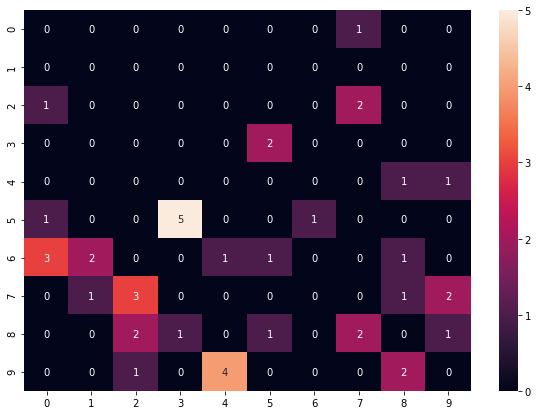

In [10]:
df_cm = pd.DataFrame(wrong, index = [i for i in "0123456789"],
                  columns = [i for i in "0123456789"])
plt.figure(figsize = (10,7))
sn.heatmap(df_cm, annot=True)